In [389]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cv2
import skimage
import random
import os
from PIL import ImageFont, ImageDraw, Image

%matplotlib inline

In [390]:
from image_processing.process import find_table_and_bottom, extract_table_boxes, extract_blocks 
from image_processing.utils import *

In [391]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [392]:
%autoreload 2

In [393]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [394]:
# IMG_PATH = 'images/ex1.jpg'
# IMG_PATH = 'images/photo_to_scan_aa.jpg'
# IMG_PATH = 'images/ex1.jpg'
# IMG_PATH = 'images/scans/ex1.jpg'

In [395]:
scans_dir = 'images/scans'

scan_files = os.listdir(scans_dir)

IMG_PATH = scans_dir + '/' + random.choice(scan_files)
IMG_PATH

'images/scans/SCAN0044.JPG'

In [396]:
img = Image.open(IMG_PATH).convert('L')
img_np = np.asarray(img)

In [397]:
# plt.imshow(img_np, cmap='gray')
# plt.show()

# Full pipeline

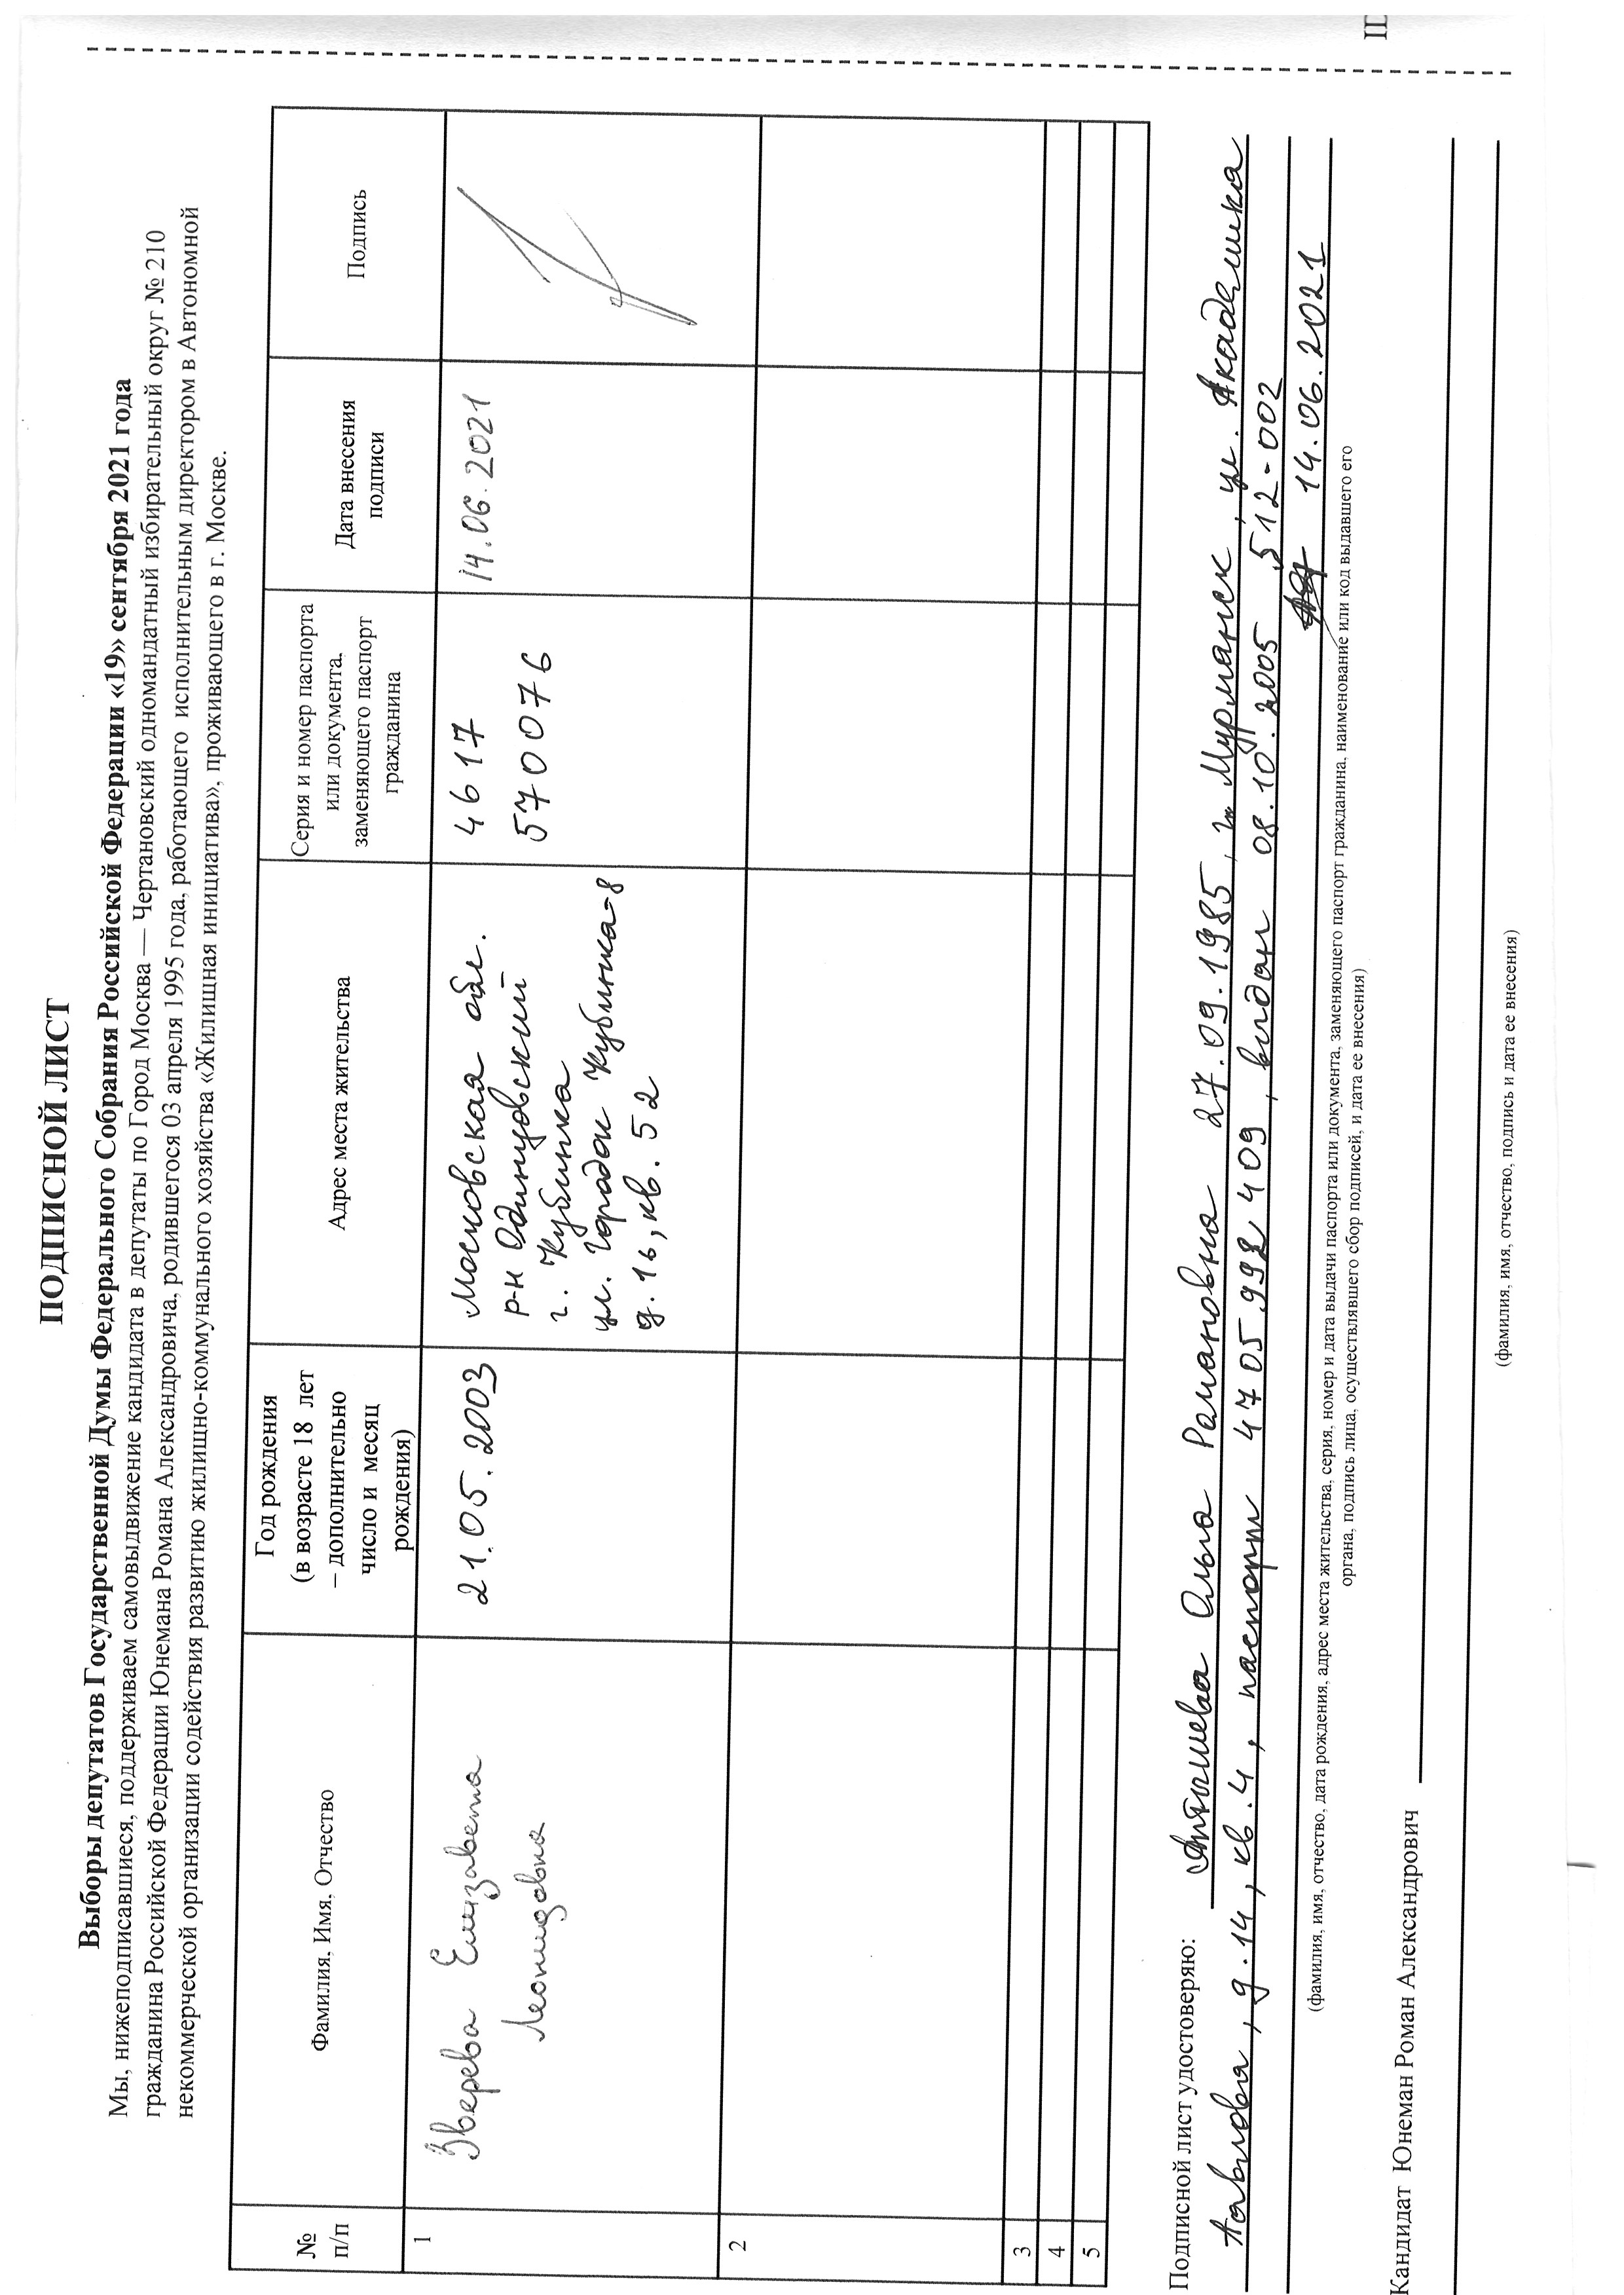

In [398]:
img

In [399]:
img.size

(2480, 3504)

# Run processing

In [400]:
np.array(img).shape

(3504, 2480)

In [401]:
result = extract_blocks(np.array(img), debug=True)

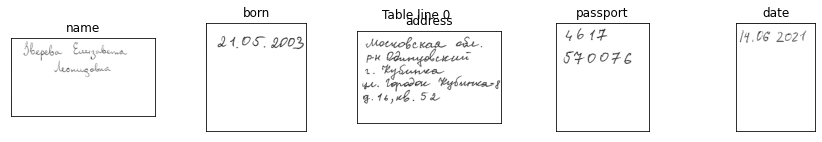

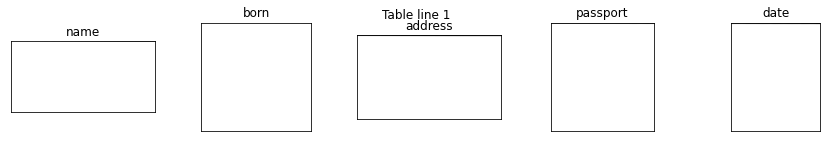

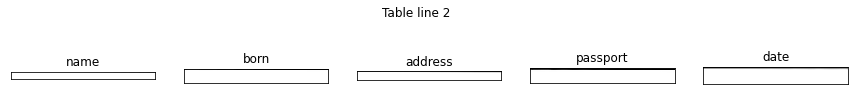

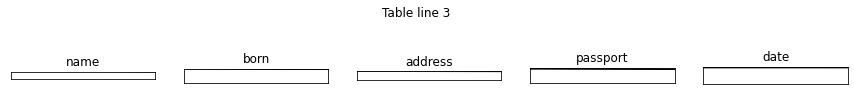

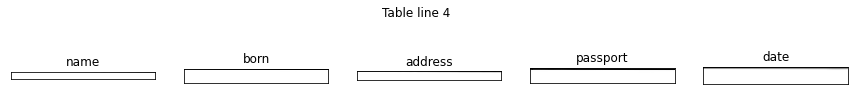

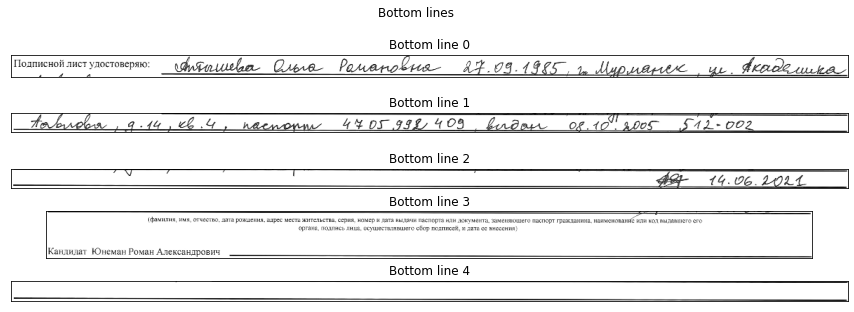

In [402]:
def plot_result(result):
    for i, line in enumerate(result['table_lines']):
        plt.figure(figsize=(15, 2))
        plt.suptitle(f'Table line {i}')
        for j, (key, cell_img) in enumerate(line.items()):
            plt.subplot(1, 5, j+1)
            plt.imshow(cell_img, cmap=plt.cm.gray)
            plt.title(key)
            plt.gca().axes.xaxis.set_visible(False)
            plt.gca().axes.yaxis.set_visible(False)


        plt.show()

    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Bottom lines')
    for i, line in enumerate(result['bottom_lines']):

        plt.subplot(5, 1, i+1)
        plt.imshow(line, cmap=plt.cm.gray)
        plt.title(f'Bottom line {i}')
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)
    plt.show()
    
plot_result(result)

# Test it!

### Random rotation

In [406]:
angle = random.randrange(-15, 15)

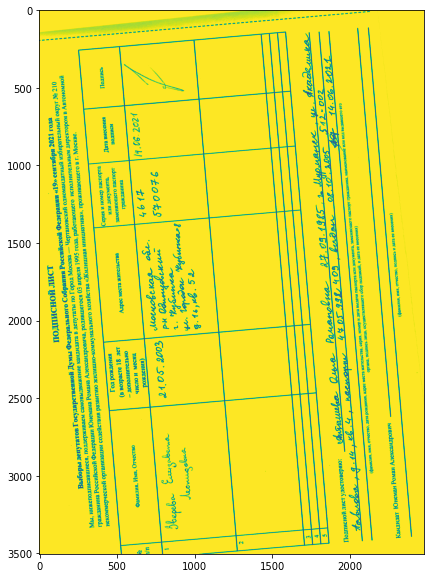

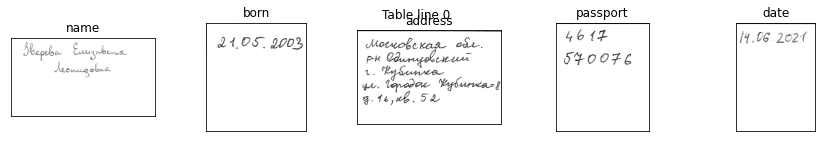

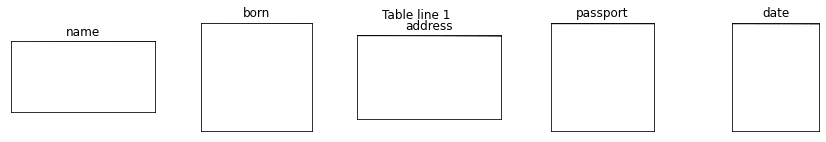

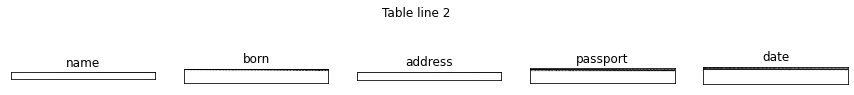

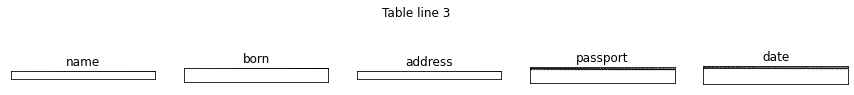

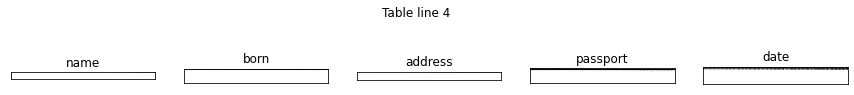

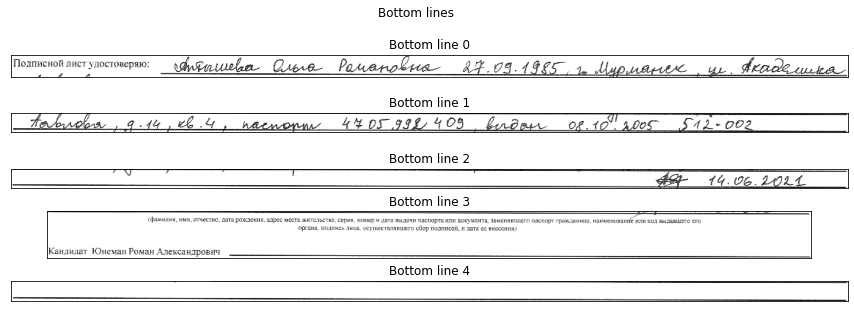

In [407]:
img_altered = img.rotate(angle, fillcolor = 255)
plt.figure()
plt.imshow(img_altered)
plt.show()
result = extract_blocks(np.array(img_altered), debug=True)
plot_result(result)

### Noise

In [408]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = random.randrange(0, 255)
            else:
                output[i][j] = image[i][j]
    return output


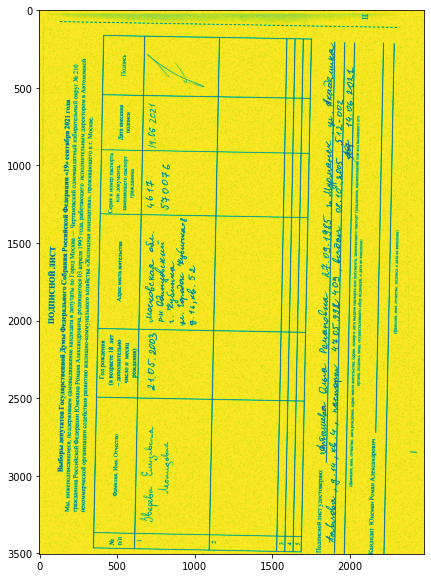

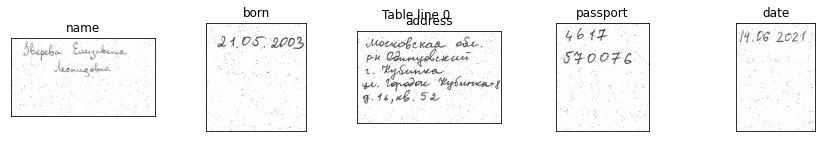

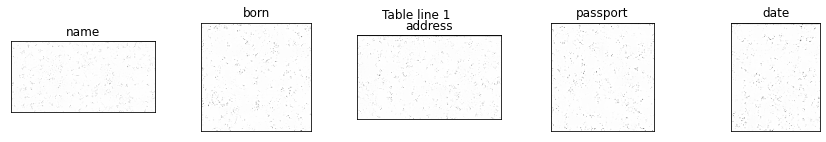

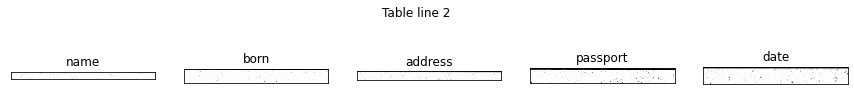

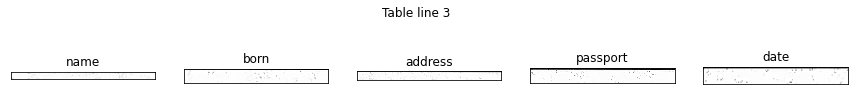

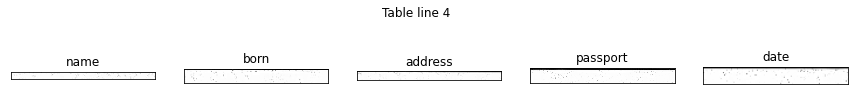

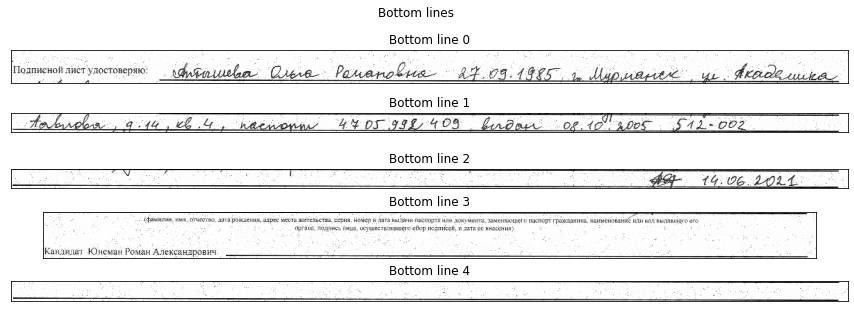

In [409]:
img_altered = sp_noise(np.array(img), 0.01)
plt.figure()
plt.imshow(img_altered)
plt.show()
result = extract_blocks(np.array(img_altered), debug=True)
plot_result(result)

### Random text fragments

In [ ]:
np.array(img).shape

In [ ]:
img_altered

In [ ]:
text_img

In [ ]:
strlen = random.randrange(5, 40)
random_str = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(strlen))
img_altered = np.array(img)
font = cv2.FONT_HERSHEY_SIMPLEX

random_x = random.randrange(0, img_altered.shape[1])
random_y = random.randrange(0, img_altered.shape[0])
scale = random.randrange(1, 3)
thickness = random.randrange(1, 10)
cv2.putText(img_altered, random_str, (random_x, random_y), font, scale, 0, thickness)

plt.figure()
plt.imshow(img_altered)
plt.show()
result = extract_blocks(np.array(img_altered), debug=True)
plot_result(result)

# Pytesseract

In [ ]:
# https://tesseract-ocr.github.io/tessdoc/Installation.html
from image_processing.tesseract_ocr import *

In [ ]:
lines = result['table_lines']
for key in lines[0].keys():
    recognized = img_to_string(lines[0][key])
    print(recognized)
    plt.figure(figsize=(7, 4))
    plt.title(f'OCR: {recognized}')
    plt.imshow(lines[0][key], cmap=plt.cm.gray)
    plt.show()

In [ ]:
for line_img in result['bottom_lines']:
    recognized = img_to_string(line_img)
    print(recognized)
    plt.figure(figsize=(7, 4))
    plt.imshow(line_img, cmap=plt.cm.gray)
    plt.show()